## Data preparation

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
customers = pd.read_csv("./Data/twm_customer.csv", sep = ";")
customers = customers[['cust_id', 'income', 'age', 'years_with_bank', 'nbr_children', 'gender', 'city_name']]
customers['city_name'] = customers['city_name'].str.strip()
customers

,cust_id,income,age,years_with_bank,nbr_children,gender,city_name
0,1362691,26150,46,5,1,M,Las Vegas
1,1362487,6605,71,1,0,M,Los Angeles
2,1363160,18548,38,8,0,F,Los Angeles
3,1362752,47668,54,3,0,F,Los Angeles
4,1362548,44554,59,9,2,F,New York City
...,...,...,...,...,...,...,...
742,1363324,14795,36,6,1,F,Los Angeles
743,1362895,26387,56,6,1,M,New York City
744,1362569,61300,50,0,2,M,Albuquerque
745,1363364,15100,37,7,0,F,Birmingham


In [4]:
#average amount per transaction
transactions = pd.read_csv("./Data/twm_transactions.csv", sep = ";")
transactions['tran_amt'] = abs(transactions['tran_amt'])
transactions = transactions.groupby('acct_nbr').agg({'principal_amt': 'count', 'tran_amt': 'sum'}).reset_index()
transactions['avg(amount/tran)'] = transactions['tran_amt']/transactions['principal_amt']
transactions = transactions.drop(columns=['principal_amt','tran_amt'])

transactions.head(3)


,acct_nbr,avg(amount/tran)
0,13624802,140.497475
1,13624803,128.769231
2,13624842,77.955758


In [5]:
#selecting active accounts and relevant columns
accounts = pd.read_csv("./Data/twm_accounts.csv", sep = ";")
accounts['account_active'] = accounts['account_active'].str.strip()
accounts['acct_type'] = accounts['acct_type'].str.strip()
accounts = accounts[accounts.account_active == "Y"]
accounts1 = accounts[['acct_nbr','cust_id']]

accounts1



,acct_nbr,cust_id
0,13628063,1362806
1,4561143213627090,1362709
2,4561143213628360,1362836
3,13633112,1363311
4,4561143213633610,1363361
...,...,...
1403,13626022,1362602
1405,4561143213626240,1362624
1406,4561143213628750,1362875
1407,13626543,1362654


In [6]:
credit_acct = pd.read_csv("./Data/twm_credit_acct.csv", sep = ";")
savings_acct = pd.read_csv("./Data/twm_savings_acct.csv", sep = ";")

results = accounts1.merge(transactions, how='left', on='acct_nbr')
results = results.groupby(['cust_id']).sum().reset_index()
results = results.drop(columns = 'acct_nbr')

results = results.merge(credit_acct[['cust_id','ending_balance']], how='left', on='cust_id')
results = results.merge(savings_acct[['cust_id','ending_balance']], how='left', on='cust_id')
results = results.merge(accounts[accounts.acct_type == "CK"][['cust_id', 'ending_balance']], how='left', on='cust_id')

results = results.rename(columns = {'ending_balance_x':'credit_balance', 'ending_balance_y': 'savings_balance','ending_balance': 'checking_balance'})
results[['credit_balance','savings_balance','checking_balance']] = results[['credit_balance','savings_balance','checking_balance']].replace(0,1)
results[['credit_balance','savings_balance','checking_balance']] = results[['credit_balance','savings_balance','checking_balance']].fillna(0)

results = results.merge(customers, how='inner', on='cust_id')

results


,cust_id,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,age,years_with_bank,nbr_children,gender,city_name
0,1362480,269.266706,20.00,1187.97,86.86,50890,33,3,2,M,New York City
1,1362484,381.386000,369.72,2122.17,95.32,10053,42,2,0,F,Denver
2,1362485,278.479306,1100.00,0.00,45.49,22690,25,4,0,F,New York City
3,1362486,98.289600,0.00,116.24,3312.27,10701,76,6,0,F,Dallas
4,1362487,211.563389,1548.23,12.89,1401.21,6605,71,1,0,M,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...
637,1363486,0.000000,1.00,0.00,0.00,39942,41,1,5,F,Honolulu
638,1363490,2.853333,0.00,2301.53,0.00,0,15,7,0,F,Honolulu
639,1363492,1103.970502,6869.00,1116.10,106.14,142274,54,4,0,M,Dallas
640,1363493,147.857778,1.00,553.61,2053.90,30068,69,5,0,M,Houston


In [21]:
results.describe()

,cust_id,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,age,years_with_bank,nbr_children
count,6.420000e+02,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,1.362987e+06,267.511660,862.004548,817.514330,490.906885,22631.669782,42.543614,3.816199,0.697819
std,2.960027e+02,279.851598,1278.006659,1766.344753,1050.571339,21698.548454,18.879918,2.695206,1.104082
min,1.362480e+06,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,1.362723e+06,121.214861,0.000000,0.000000,0.000000,7440.000000,28.000000,2.000000,0.000000
50%,1.362984e+06,215.972650,512.895000,236.190000,84.740000,17406.500000,41.000000,4.000000,0.000000
75%,1.363246e+06,312.781014,1014.890000,925.057500,512.792500,31007.000000,56.000000,6.000000,1.000000
max,1.363495e+06,4045.654571,9500.000000,22432.780000,13185.470000,144157.000000,89.000000,9.000000,5.000000


In [22]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 641
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           642 non-null    int64  
 1   avg(amount/tran)  642 non-null    float64
 2   credit_balance    642 non-null    float64
 3   savings_balance   642 non-null    float64
 4   checking_balance  642 non-null    float64
 5   income            642 non-null    int64  
 6   age               642 non-null    int64  
 7   years_with_bank   642 non-null    int64  
 8   nbr_children      642 non-null    int64  
 9   gender            642 non-null    object 
 10  city_name         642 non-null    object 
dtypes: float64(4), int64(5), object(2)
memory usage: 60.2+ KB


<Axes: >

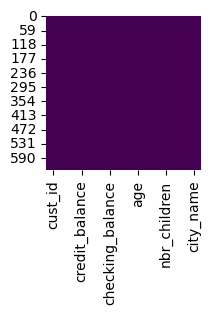

In [23]:
plt.figure(figsize=(2,2))
sns.heatmap(results.isnull(),cbar=False,cmap='viridis')


In [24]:
#checking for wrong entries
for col in results.columns:
    print('{}:{}'.format(col, results[col].unique()))

cust_id:[1362480 1362484 1362485 1362486 1362487 1362488 1362489 1362492 1362496
 1362497 1362498 1362499 1362500 1362501 1362502 1362503 1362505 1362506
 1362507 1362508 1362509 1362510 1362511 1362512 1362513 1362516 1362520
 1362523 1362524 1362525 1362526 1362528 1362529 1362530 1362531 1362535
 1362537 1362540 1362541 1362542 1362546 1362547 1362548 1362549 1362550
 1362551 1362552 1362555 1362556 1362557 1362562 1362563 1362565 1362567
 1362568 1362569 1362570 1362571 1362572 1362573 1362574 1362577 1362578
 1362579 1362580 1362584 1362585 1362586 1362587 1362588 1362589 1362590
 1362591 1362592 1362593 1362594 1362595 1362596 1362597 1362602 1362604
 1362605 1362606 1362607 1362609 1362610 1362611 1362613 1362614 1362617
 1362619 1362620 1362621 1362622 1362623 1362624 1362625 1362630 1362631
 1362632 1362633 1362636 1362637 1362638 1362640 1362641 1362642 1362643
 1362644 1362645 1362649 1362650 1362652 1362653 1362654 1362656 1362657
 1362658 1362659 1362661 1362662 1362663 13

In [7]:
#saving results
results.to_csv('./Data/cluster_data.csv', index = False)